In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
import torch 
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
class WindowDataset(Dataset):
    # 단변량 시계열에서 입력 값 정답 값을 만드는 Dataset
    def __init__(self, _data, _window):
        # _data : (N, ) 형태의 1차원 tensor 데이터
        # _window : 과거의 몇개의 데이터를 볼것인가?(구간 설정)
        self.data = _data
        self.window = _window
        # 유효 샘플의 개수는 학습 데이터의 개수는 data의 전체 길이에서 -1
        # 입력 데이터는 전체 길이 - 윈도우 
        self.n = len(_data) - _window

    # __len__(), __getitem__() 두개의 특수 함수들은 
    # DataLoder에서 자동으로 호출해서 사용이 되는 부분
    def __len__(self):
        return max(self.n, 0)
    
    def __getitem__(self, idx):
        # 변환
        # x -> 입력 데이터 (윈도우의 구간을 나타내는 데이터) --> 문제
        # y -> 입력 데이터 다음 행의 데이터  --> 정답
        x = self.data[idx : idx + self.window].unsqueeze(-1) # (window, ) -> (window, 1)
        y = self.data[idx + self.window].unsqueeze(-1)
        return x, y

In [ ]:
# RNN class 정의 
class RNNReg(nn.Module):
    # 해당 class에서 정의되는 함수는 생성자함수, forward()함수

    def __init__(
            self, 
            input_size, 
            hidden_size, 
            num_layers = 1, 
            nonlinearity = 'tanh', 
            dropout = 0.0, 
            bidirectional = False, 
            batch_first = True
    ):
        # 부모 클래스의 생성자 함수 호출 
        super().__init__()
        self.rnn = nn.RNN(
            input_size = input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers, 
            nonlinearity=nonlinearity, 
            dropout=dropout, 
            bidirectional=bidirectional, 
            batch_first=batch_first
        )
        # self.head = nn.Linear(hidden_size, 1) # 1차원 스칼라 회귀
        # bidirectional의 값이 False 인 경우에는 hidden_size를 사용
        # 만약 True라면 hidden_size * 2
        out_features = hidden_size * ( 2 if bidirectional else 1 )
        # 선형 학습 모델 -> 비선형 학습 모델 
        # self.head = nn.Linear(out_features, 1)
        self.head = nn.Sequential(
            nn.Linear(out_features, out_features*2), 
            nn.ReLU(), 
            nn.Linear(out_features*2, 1)
        )

    def forward(self, x):
        # out -> 모든 시점에서의 은닉층의 값(결과)
        # h_n -> 마지막 시점에서의 은닉층의 값(결과) -> 층이 존재하면 층별 마지막 값
        #  -> 시계열 분석은 마지막 시점을 사용
        out, h_n = self.rnn(x)
        # 가장 마지막 은닉의 값을 사용(마지막 층의 값)
        last_hidden = h_n[-1]
        res =  self.head(last_hidden)
        return res


### 문제 
- csv 폴더 안에 있는 AAPL.csv 파일을 로드 
- 해당 데이터프레임에서 Date, Adj Close 컬럼을 제외한 나머지는 모두 삭제 
- 결측치가 포함되어있는지 확인하고 결측치 데이터가 전체 데이터 수의 비해 매우 작은 크기라면 제거  
- 해당 데이터 셋의 순서가 시간의 순서와 같은지 확인 (시간 컬럼을 기준으로 오름차순 정렬)
- tensor 데이터를 생성하기 위해 Adj Close의 데이터 array 형태( (N, 1) )로 변경
- train, test의 비율이 75:25의 비율로 데이터를 나눠준다. 
- train과 test를 스케일러를 이용하여 스케일링
- train과 test를 Tensor의 형태로 변환 
- Tensor의 형태로 변환된 데이터를 WindowDataset의 형태로 변경하고 DataLoader를 이용하여 학습에서 사용하기 편한 형태로 변경 (window의 개수는 60)

In [ ]:
df = pd.read_csv("../csv/AAPL.csv")
df.info()

In [ ]:
# Date, Adj Close 컬럼을 제외한 나머지는 모두 제거 
df2 = df.drop( ['Open', 'High', 'Low', 'Close', 'Volume'] , axis=1)
df2

In [ ]:
df = df[['Date', 'Adj Close']]

In [ ]:
df.info()

In [ ]:
# 결측치의 개수 / 전체 데이터의 개수 * 100
# 결측치가 포함된 행의 개수
na_cnt = df.isna().any(axis=1).sum()
round( na_cnt / len(df) * 100 , 2 )

In [ ]:
# 결측치의 개수가 전체 데이터에 비해 매우 적다. -> 그냥 제거
# 결측치가 포함되어있는 행을 제외하고 필터링 
df.loc[ ~df.isna().any(axis=1),  ]

In [ ]:
# 결측치가 포함되어있는 행을 제거
df.dropna(axis=0, inplace=True)

In [ ]:
# Date을 기준으로 오름차순 정렬 
df.sort_values('Date', inplace=True)

In [ ]:
# Adj Close의 values을 2차원 array의 형태로 변환 
df['Adj Close'].values.reshape(-1, 1)

In [ ]:
values = df[['Adj Close']].values

In [ ]:
# 75 : 25 비율로 데이터 분할 
split_idx = int( len(values) * 0.75 )

train_data = values[ : split_idx]
test_data = values[split_idx : ]
print(train_data.shape, test_data.shape)

In [ ]:
# StandardScaler 스케일러를 이용하여 스케일링 작업 
scaler = MinMaxScaler()
train_sc = scaler.fit_transform(train_data)
test_sc = scaler.transform(test_data)

In [ ]:
# 스케일링이 완료된 데이터셋을 tensor형태로 변환
train_sc = torch.tensor(train_sc.squeeze(-1), dtype=torch.float32)
test_sc = torch.tensor(test_sc.squeeze(-1), dtype=torch.float32)

In [ ]:
train_ds = WindowDataset(train_sc, 60)
test_ds = WindowDataset(test_sc, 60)

In [ ]:
train_dl = DataLoader(train_ds, shuffle=True, drop_last=True, batch_size=128)
test_dl = DataLoader(test_ds, shuffle=False, drop_last=False, batch_size=256)

In [ ]:
# 반복 학습 루프 생성 
# 모델 생성
aapl_model = RNNReg(input_size=1, hidden_size=128)
# 손실함수 
criterion = nn.MSELoss()
# 옵티마이저 
optimizer = optim.Adam(aapl_model.parameters(), lr = 0.001)


In [ ]:

# 평가 함수 생성 
# 함수 호출시 동시에 실행이 되는 데코레이터 생성 
@torch.no_grad()
def evaluate_mse(dataloader):
    aapl_model.eval()
    total_loss, total_n = 0.0, 0
    # with torch.no_grad():
    for x, y in dataloader:
        x = x.float()
        y = y.float()
        yhat = aapl_model(x)
        loss = criterion(yhat, y)
        total_loss += loss.item() * y.size(0)
        total_n += y.size(0)
    return total_loss / max(total_n, 1)

train_history, val_history = [], []
for epoch in range(20):
    aapl_model.train()
    running, n_seen = 0.0, 0
    for x, y in train_dl:
        x = x.float()
        y = y.float()

        optimizer.zero_grad()
        yhat = aapl_model(x)
        loss = criterion(yhat, y)
        loss.backward()

        # 기울기 폭발 방지 -> nan값이 나올수 있는 확률은 배제
        nn.utils.clip_grad_norm_(aapl_model.parameters(), 1.0)

        optimizer.step()

        running += loss.item() * y.size(0)
        n_seen += y.size(0)
    train_mse = running / max(n_seen, 1)
    val_mse = evaluate_mse(test_dl)
    train_history.append(train_mse)
    val_history.append(val_mse)
    print(f"Epoch : {epoch+1}, train_mse : {round(train_mse, 4)}, val_mse : {round(val_mse, 4)}")


In [ ]:
# 검증 셋 예측의 값과 실제의 값을 그래프 시각화
aapl_model.eval()

preds = []
trues = []

with torch.no_grad():
    for x, y in test_dl:
        x = x.float()
        y = y.float()
        yhat = aapl_model(x)
        preds.append(yhat.cpu())
        trues.append(y.cpu())

# preds, trues를 numpy형태로 변환 
preds = torch.cat(preds, dim=0).squeeze(-1).numpy()
trues = torch.cat(trues, dim=0).squeeze(-1).numpy()

plt.figure(figsize=(14, 10))
plt.plot(preds[:600], label='Pred Data')
plt.plot(trues[:600], label='True Data')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 스케일링 데이터를 다시 원본의 데이터셋으로 변경 
# inverse_transform() : 스케일링 데이터를 원본으로 변경 
preds_origin = scaler.inverse_transform(preds.reshape(-1, 1)).squeeze()
trues_origin = scaler.inverse_transform(trues.reshape(-1, 1)).squeeze()


In [ ]:
plt.figure(figsize=(14, 10))
plt.plot(preds_origin, label='Pred Origin Data')
plt.plot(trues_origin, label='True Origin Data')

plt.legend()

plt.show()

In [ ]:
# 시계열 분석
# 2개의 피쳐(종가, 거래량) -> 타깃(종가) 예측 

df = pd.read_csv("../csv/AAPL.csv")

In [ ]:
# 특정 컬럼을 선택 
df = df[['Date', 'Adj Close', 'Volume']]
df.dropna(axis=0, inplace=True)

In [ ]:
# 피쳐 데이터(독립)
X_all = df[['Adj Close', 'Volume']].astype('float').values
# 타깃 데이터(종속)
Y_all = df[['Adj Close']].astype('float').values

In [ ]:
# 데이터의 분할 -> 4개의 데이터가 생성 -> 8:2
# train_test_split() 함수와 같은 부분
split_idx = int(len(df) * 0.8)

X_train, X_test = X_all[ : split_idx], X_all[split_idx : ]
Y_train, Y_test = Y_all[ : split_idx], Y_all[split_idx : ]

In [ ]:
# 스케일러를 스케일링-> (마지막에 예측 종가, 실제 종가의 데이터의 원본으로 역변환을 편하게 하기 위함)
x_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train_sc = x_scaler.fit_transform(X_train)
X_test_sc = x_scaler.transform(X_test)

Y_train_sc = y_scaler.fit_transform(Y_train)
Y_test_sc = y_scaler.transform(Y_test)

In [ ]:
# DataLoader에서 구간 데이터를 나눠주긴 위한 DataSet 구성 
class WindowDS(Dataset):
    def __init__(self, _x, _y, _window):
        # _x : 독립
        # _y : 종속
        # _window : 구간 
        self.x = _x
        self.y = _y
        self.window = _window
        self.n = len(_x) - _window
    # DataLoader에서 사용되는 특수 메서드 정의 : __len__(), __getitem__()
    def __len__(self):
        return max(self.n, 1)

    def __getitem__(self, idx):
        # 입력 데이터 (문제)
        x_window = self.x[idx : idx + self.window]
        # 타깃 데이터 (정답)
        y_next = self.y[idx + self.window]
        # tersor 데이터로 변환 (self.x, self.y를 array형태로 받는다는 가정)
        # tensor() -> 텐서형으로 데이터를 변환 (깊은 복사 -> 데이터를 각각의 다른 위치에 저장)
        # from_numpy() -> 텐서형으로 데이터를 변환(얕은 복사 -> 데이터는 위치는 같고 라벨을 추가)
        x_tensor = torch.from_numpy(x_window)
        y_tensor = torch.from_numpy(y_next)
        return x_tensor, y_tensor



In [ ]:
# RNN class 정의 
class RNNReg(nn.Module):
    # 해당 class에서 정의되는 함수는 생성자함수, forward()함수

    def __init__(
            self, 
            input_size, 
            hidden_size, 
            num_layers = 1, 
            nonlinearity = 'tanh', 
            dropout = 0.0, 
            bidirectional = False, 
            batch_first = True
    ):
        # 부모 클래스의 생성자 함수 호출 
        super().__init__()
        self.rnn = nn.RNN(
            input_size = input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers, 
            nonlinearity=nonlinearity, 
            dropout=dropout, 
            bidirectional=bidirectional, 
            batch_first=batch_first
        )
        # self.head = nn.Linear(hidden_size, 1) # 1차원 스칼라 회귀
        # bidirectional의 값이 False 인 경우에는 hidden_size를 사용
        # 만약 True라면 hidden_size * 2
        out_features = hidden_size * ( 2 if bidirectional else 1 )
        # 선형 학습 모델 -> 비선형 학습 모델 
        # self.head = nn.Linear(out_features, 1)
        self.head = nn.Sequential(
            nn.Linear(out_features, out_features*2), 
            nn.ReLU(), 
            nn.Linear(out_features*2, 1)
        )

    def forward(self, x):
        # out -> 모든 시점에서의 은닉층의 값(결과)
        # h_n -> 마지막 시점에서의 은닉층의 값(결과) -> 층이 존재하면 층별 마지막 값
        #  -> 시계열 분석은 마지막 시점을 사용
        out, h_n = self.rnn(x)
        # 가장 마지막 은닉의 값을 사용(마지막 층의 값)
        last_hidden = h_n[-1]
        res =  self.head(last_hidden)
        return res


In [ ]:
# 구간별 데이터셋을 구성 
train_ds = WindowDS(X_train_sc, Y_train_sc, 60)
test_ds = WindowDS(X_test_sc, Y_test_sc, 60)

train_dl = DataLoader(train_ds, shuffle=True, drop_last=True, batch_size=64)
test_dl = DataLoader(test_ds, shuffle=False, drop_last=False, batch_size=256)

In [104]:
# 반복 학습 루프 생성 
# 모델 생성
aapl_model = RNNReg(input_size=2, hidden_size=128)
# 손실함수 
criterion = nn.MSELoss()
# 옵티마이저 
optimizer = optim.Adam(aapl_model.parameters(), lr = 0.001)

In [105]:

# 평가 함수 생성 
# 함수 호출시 동시에 실행이 되는 데코레이터 생성 
@torch.no_grad()
def evaluate_mse(dataloader):
    aapl_model.eval()
    total_loss, total_n = 0.0, 0
    # with torch.no_grad():
    for x, y in dataloader:
        x = x.float()
        y = y.float()
        yhat = aapl_model(x)
        loss = criterion(yhat, y)
        total_loss += loss.item() * y.size(0)
        total_n += y.size(0)
    return total_loss / max(total_n, 1)

train_history, val_history = [], []
for epoch in range(20):
    aapl_model.train()
    running, n_seen = 0.0, 0
    for x, y in train_dl:
        x = x.float()
        y = y.float()

        optimizer.zero_grad()
        yhat = aapl_model(x)
        loss = criterion(yhat, y)
        loss.backward()

        # 기울기 폭발 방지 -> nan값이 나올수 있는 확률은 배제
        nn.utils.clip_grad_norm_(aapl_model.parameters(), 1.0)

        optimizer.step()

        running += loss.item() * y.size(0)
        n_seen += y.size(0)
    train_mse = running / max(n_seen, 1)
    val_mse = evaluate_mse(test_dl)
    train_history.append(train_mse)
    val_history.append(val_mse)
    print(f"Epoch : {epoch+1}, train_mse : {round(train_mse, 4)}, val_mse : {round(val_mse, 4)}")


Epoch : 1, train_mse : 0.0741, val_mse : 29.2484
Epoch : 2, train_mse : 0.0015, val_mse : 28.0058
Epoch : 3, train_mse : 0.0012, val_mse : 26.865
Epoch : 4, train_mse : 0.0013, val_mse : 25.7844
Epoch : 5, train_mse : 0.001, val_mse : 23.1019
Epoch : 6, train_mse : 0.0009, val_mse : 21.5235
Epoch : 7, train_mse : 0.001, val_mse : 21.0982
Epoch : 8, train_mse : 0.0008, val_mse : 20.2464
Epoch : 9, train_mse : 0.0009, val_mse : 18.8072
Epoch : 10, train_mse : 0.0011, val_mse : 17.6388
Epoch : 11, train_mse : 0.0015, val_mse : 15.2428
Epoch : 12, train_mse : 0.0011, val_mse : 14.7616
Epoch : 13, train_mse : 0.0008, val_mse : 15.2424
Epoch : 14, train_mse : 0.0008, val_mse : 14.3856
Epoch : 15, train_mse : 0.0008, val_mse : 13.3641
Epoch : 16, train_mse : 0.0009, val_mse : 13.1844
Epoch : 17, train_mse : 0.0008, val_mse : 13.5967
Epoch : 18, train_mse : 0.0007, val_mse : 12.2051
Epoch : 19, train_mse : 0.0007, val_mse : 13.7184
Epoch : 20, train_mse : 0.0008, val_mse : 12.5483


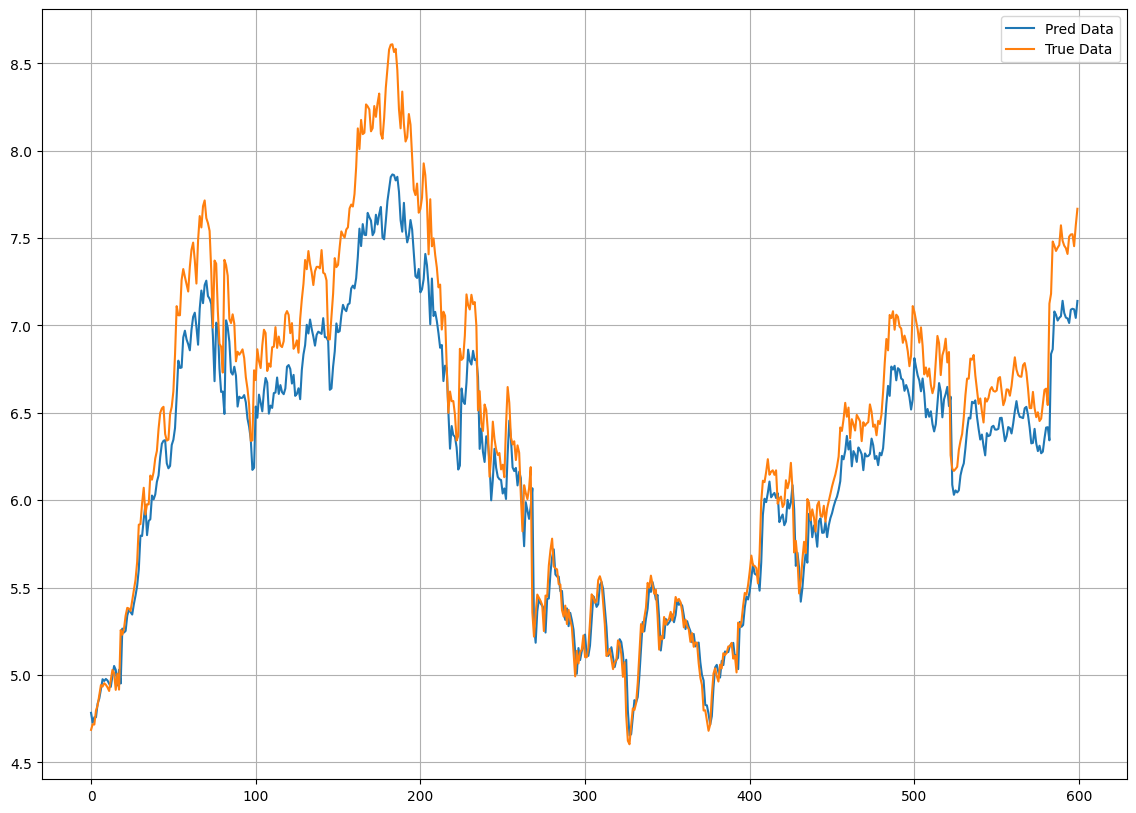

In [106]:
# 검증 셋 예측의 값과 실제의 값을 그래프 시각화
aapl_model.eval()

preds = []
trues = []

with torch.no_grad():
    for x, y in test_dl:
        x = x.float()
        y = y.float()
        yhat = aapl_model(x)
        preds.append(yhat.cpu())
        trues.append(y.cpu())

# preds, trues를 numpy형태로 변환 
preds = torch.cat(preds, dim=0).squeeze(-1).numpy()
trues = torch.cat(trues, dim=0).squeeze(-1).numpy()

plt.figure(figsize=(14, 10))
plt.plot(preds[:600], label='Pred Data')
plt.plot(trues[:600], label='True Data')
plt.legend()
plt.grid(True)
plt.show()

In [107]:
# 스케일링 데이터를 다시 원본의 데이터셋으로 변경 
# inverse_transform() : 스케일링 데이터를 원본으로 변경 
preds_origin = y_scaler.inverse_transform(preds.reshape(-1, 1)).squeeze()
trues_origin = y_scaler.inverse_transform(trues.reshape(-1, 1)).squeeze()


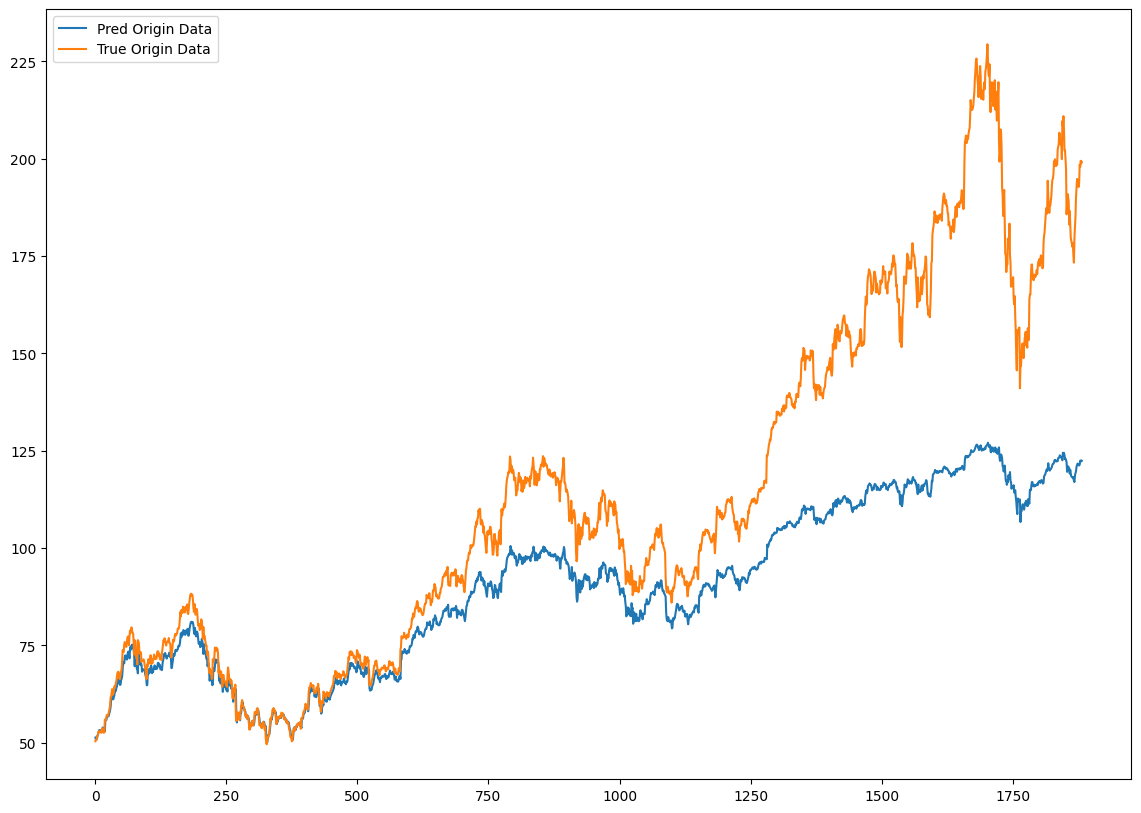

In [108]:
plt.figure(figsize=(14, 10))
plt.plot(preds_origin, label='Pred Origin Data')
plt.plot(trues_origin, label='True Origin Data')

plt.legend()

plt.show()